![](img/330-banner.png)

## Lecture 5: Preprocessing and `sklearn` pipelines

UBC 2020-21

Instructor: Varada Kolhatkar

In [1]:
# Import libraries
import time
from hashlib import sha1

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import HTML

# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier
from sklearn.compose import ColumnTransformer

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import euclidean_distances

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

pd.set_option("display.max_colwidth", 200)

## Lecture learning objectives

From this lecture, you will be able to 

- identify when to implement feature transformations such as imputation, scaling, and one-hot encoding in a machine learning model development pipeline; 
- use `sklearn` for applying feature transformations on your dataset;
- discuss golden rule in the context of feature transformations;
- use `sklearn.pipeline.Pipeline` to build a preliminary machine learning pipeline; 
- use `ColumnTransformer` to build all our transformations together into one object and use it with `sklearn` pipelines.  

### Lecture outline

1. [Introduction and motivation](#1)
2. [Dataset and baseline](#2)
2. [Imputation](#3)
3. [Scaling](#4)
3. [Feature transformations and the golden rule](#5)
5. [Categorical variables](#6)
6. [ColumnTransformer](#7)

## Motivation and big picture <a name="1"></a>

- So far we have seen
    - Three ML models (decision trees, $k$-NNs, SVMs with RBF kernel)
    - ML fundamentals (train-validation-test split, cross-validation, the fundamental tradeoff, the golden rule)
- Are we ready to do machine learning on real-world datasets?
    - Very often real-world datasets need preprocessing before we use them to build ML models. 

### Example: $k$-nearest neighbours on the Spotify dataset

- In lab1 you used `DecisionTreeClassifier` to predict whether the user would like a particular song or not. 
- Can we use $k$-NN classifier for this task? 
- Intuition: To predict whether the user likes a particular song or not (query point) 
   - find the songs that are closest to the query point
   - let them vote on the target
   - take the majority vote as the target for the query point
   

In [2]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)
train_df, test_df = train_test_split(spotify_df, test_size=0.20, random_state=123)
X_train, y_train = (
    train_df.drop(columns=["song_title", "artist", "target"]),
    train_df["target"],
)
X_test, y_test = (
    test_df.drop(columns=["song_title", "artist", "target"]),
    test_df["target"],
)

In [3]:
dummy = DummyClassifier(strategy="most_frequent")
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)

Mean validation score 0.508


,fit_time,score_time,test_score,train_score
0,0.000803,0.000261,0.507740,0.507752
1,0.000472,0.000192,0.507740,0.507752
2,0.000480,0.000198,0.507740,0.507752
3,0.000462,0.000195,0.506211,0.508133
4,0.000455,0.000193,0.509317,0.507359


In [4]:
knn = KNeighborsClassifier()
scores = cross_validate(knn, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)

Mean validation score 0.546


,fit_time,score_time,test_score,train_score
0,0.002725,0.008658,0.563467,0.717829
1,0.002271,0.007856,0.535604,0.721705
2,0.001996,0.007735,0.529412,0.708527
3,0.002061,0.007808,0.537267,0.721921
4,0.001945,0.007580,0.562112,0.711077


In [5]:
two_songs = X_train.sample(2, random_state=42)
two_songs

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
842,0.229000,0.494,147893,0.666,0.000057,9,0.0469,-9.743,0,0.0351,140.832,4.0,0.704
654,0.000289,0.771,227143,0.949,0.602000,8,0.5950,-4.712,1,0.1750,111.959,4.0,0.372


In [6]:
euclidean_distances(two_songs)

array([[    0.        , 79250.00543825],
       [79250.00543825,     0.        ]])

Let's consider only two features: `duration_ms` and `tempo`.

In [7]:
two_songs_subset = two_songs[["duration_ms", "tempo"]]
two_songs_subset

,duration_ms,tempo
842,147893,140.832
654,227143,111.959


In [8]:
euclidean_distances(two_songs_subset)

array([[    0.        , 79250.00525962],
       [79250.00525962,     0.        ]])

Do you see any problem? 

- The distance is completely dominated by the the features with larger values
- The features with smaller values are being ignored. 
- Does it matter? 
    - Yes! Scale is based on how data was collected. 
    - Features on a smaller scale can be highly informative and there is no good reason to ignore them.
    - We want our model to be robust and not sensitive to the scale. 
- Was this a problem for decision trees?


### Scaling using `scikit-learn`'s [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

- We'll use `scikit-learn`'s [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which is a `transformer`.   
- Only focus on the syntax for now. We'll talk about scaling in a bit. 

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # create feature trasformer object
scaler.fit(X_train)  # fitting the transformer on the train split
X_train_scaled = scaler.transform(X_train)  # transforming the train split
X_test_scaled = scaler.transform(X_test)  # transforming the test split
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,-0.697633,-0.194548,-0.398940,-0.318116,-0.492359,1.275623,-0.737898,0.395794,-1.280599,-0.617752,-0.293827,0.138514,-0.908149
1,-0.276291,0.295726,-0.374443,-0.795552,0.598355,-1.487342,-0.438792,-0.052394,0.780884,2.728394,-0.802595,-3.781179,-1.861238
2,-0.599540,1.110806,-0.376205,-0.946819,-0.492917,0.446734,-0.399607,-0.879457,0.780884,2.534909,0.191274,0.138514,0.575870
3,-0.307150,1.809445,-0.654016,-1.722063,-0.492168,0.170437,-0.763368,-1.460798,-1.280599,-0.608647,-0.839616,0.138514,1.825358
4,-0.634642,0.491835,-0.131344,1.057468,2.723273,0.170437,-0.458384,-0.175645,-1.280599,-0.653035,-0.074294,0.138514,-0.754491


### `fit` and `transform` paradigm for transformers
- `sklearn` uses `fit` and `transform` paradigms for feature transformations. 
- We `fit` the transformer on the train split and then transform the train split as well as the test split. 
- We apply the same transformations on the test split. 

### `sklearn` API summary: estimators

Suppose `model` is a classification or regression model. 

```
model.fit(X_train, y_train)
X_train_predictions = model.predict(X_train)
X_test_predictions = model.predict(X_test)
```    


### `sklearn` API summary: transformers

Suppose `transformer` is a transformer used to change the input representation, for example, to tackle missing values or to scales numeric features.

```
transformer.fit(X_train, [y_train])
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)
```  

- You can pass `y_train` in `fit` but it's usually ignored. It allows you to pass it just to be consistent with usual usage of `sklearn`'s `fit` method.   
- You can also carry out fitting and transforming in one call using `fit_transform`. But be mindful to use it only on the train split and **not** on the test split. 

- Do you expect `DummyClassifier` results to change after scaling the data? 
- Let's check whether scaling makes any difference for $k$-NNs. 

In [10]:
knn_unscaled = KNeighborsClassifier()
knn_unscaled.fit(X_train, y_train)
print("Train score: %0.3f" % (knn_unscaled.score(X_train, y_train)))
print("Test score: %0.3f" % (knn_unscaled.score(X_test, y_test)))

Train score: 0.726
Test score: 0.552


In [11]:
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train_scaled, y_train)
print("Train score: %0.3f" % (knn_scaled.score(X_train_scaled, y_train)))
print("Test score: %0.3f" % (knn_scaled.score(X_test_scaled, y_test)))

Train score: 0.798
Test score: 0.686


- The scores with scaled data are better compared to the unscaled data in case of $k$-NNs.
- I am not carrying out cross-validation here for a reason that we'll look into soon. 
- Note that I am a bit sloppy here and using the test set several times for teaching purposes. But when you build an ML pipeline, please do assessment on the test set only once.  

### Common preprocessing techniques

Some commonly performed feature transformation include:  
- Imputation: Tackling missing values
- Scaling: Scaling of numeric features
- One-hot encoding: Tackling categorical variables      
    

We can have one lecture on each of them! In this lesson our goal is to getting familiar with them so that we can use them to build ML pipelines. 

In the next part of this lecture, we'll build an ML pipeline using [California housing prices regression dataset](https://www.kaggle.com/harrywang/housing). In the process, we will talk about different feature transformations and how can we apply them so that we do not violate the golden rule. 

<br><br><br><br>

## Dataset, splitting, and baseline

We'll be working on [California housing prices regression dataset](https://www.kaggle.com/harrywang/housing) to demonstrate these feature transformation techniques. The task is to predict median house values in Californian districts, given a number of features from these districts. If you are running the notebook on your own, you'll have to download the data and put it in the data directory. 

In [12]:
housing_df = pd.read_csv("data/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=123)

train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN


Some column values are mean/median but some are not. 

Let's add some new features to the dataset which could help predicting the target: `median_house_value`. 

In [13]:
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

train_df = train_df.assign(
    bedrooms_per_household=train_df["total_bedrooms"] / train_df["households"]
)
test_df = test_df.assign(
    bedrooms_per_household=test_df["total_bedrooms"] / test_df["households"]
)

train_df = train_df.assign(
    population_per_household=train_df["population"] / train_df["households"]
)
test_df = test_df.assign(
    population_per_household=test_df["population"] / test_df["households"]
)

In [14]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN,3.817558,1.004801,4.323045


### When is it OK to do things before splitting? 

- Here it would have been OK to add new features before splitting because we are not using any global information in the data but only looking at one row at a time. 
- But just to be safe and to avoid accidentally breaking the golden rule, it's better to do it after splitting. 

- Question: Should we remove `total_rooms`, `total_bedrooms`, and `population` columns? 
    - Probably. But I am keeping them in this lecture. You could experiment with removing them and examine whether results change. 

### EDA 

In [15]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN,3.817558,1.004801,4.323045


The feature scales are quite different. 

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18576 entries, 6051 to 19966
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 18576 non-null  float64
 1   latitude                  18576 non-null  float64
 2   housing_median_age        18576 non-null  float64
 3   total_rooms               18576 non-null  float64
 4   total_bedrooms            18391 non-null  float64
 5   population                18576 non-null  float64
 6   households                18576 non-null  float64
 7   median_income             18576 non-null  float64
 8   median_house_value        18576 non-null  float64
 9   ocean_proximity           18576 non-null  object 
 10  rooms_per_household       18576 non-null  float64
 11  bedrooms_per_household    18391 non-null  float64
 12  population_per_household  18576 non-null  float64
dtypes: float64(12), object(1)
memory usage: 2.0+ MB


We have one categorical feature and all other features are numeric features. 

In [17]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_household,population_per_household
count,18576.000000,18576.000000,18576.000000,18576.000000,18391.000000,18576.000000,18576.000000,18576.000000,18576.000000,18576.000000,18391.000000,18576.000000
mean,-119.565888,35.627966,28.622255,2635.749677,538.229786,1428.578165,500.061100,3.862552,206292.067991,5.426067,1.097516,3.052349
std,1.999622,2.134658,12.588307,2181.789934,421.805266,1141.664801,383.044313,1.892491,115083.856175,2.512319,0.486266,10.020873
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.333333,0.692308
25%,-121.790000,33.930000,18.000000,1449.000000,296.000000,788.000000,280.000000,2.560225,119400.000000,4.439360,1.005888,2.430323
50%,-118.490000,34.250000,29.000000,2127.000000,435.000000,1167.000000,410.000000,3.527500,179300.000000,5.226415,1.048860,2.818868
75%,-118.010000,37.710000,37.000000,3145.000000,647.000000,1727.000000,606.000000,4.736900,263600.000000,6.051620,1.099723,3.283921
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,34.066667,1243.333333


- Seems like total_bedrooms column has some missing values. 
- This must have affected our new feature `bedrooms_per_household` as well. 

In [18]:
housing_df["total_bedrooms"].isnull().sum()

207

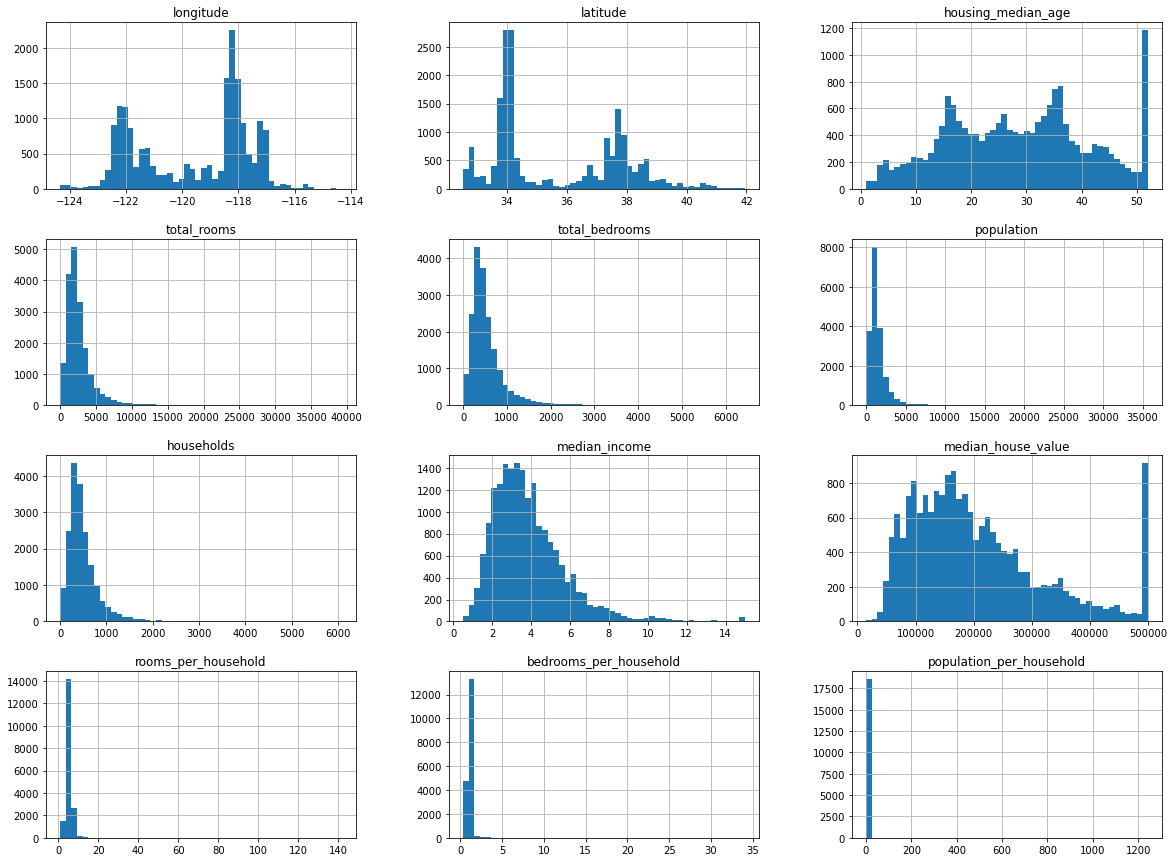

In [19]:
## (optional)
train_df.hist(bins=50, figsize=(20, 15));

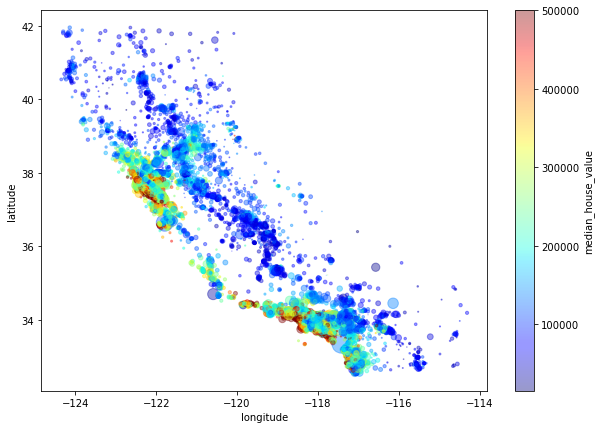

In [20]:
## (optional)
train_df.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=train_df["population"] / 100,
    figsize=(10, 7),
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    sharex=False,
);

### What all transformations we need to apply on the dataset? 

Here is what we see from the EDA. 

- Some missing values in `total_bedrooms` column
- Scales are quite different across columns. 
- Categorical variable `ocean_proximity`

Read about [preprocessing techniques implemented in `scikit-learn`](https://scikit-learn.org/stable/modules/preprocessing.html).  

In [21]:
# We are droping the categorical variable ocean_proximity for now. We'll come back to it in a bit.
X_train = train_df.drop(columns=["median_house_value", "ocean_proximity"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value", "ocean_proximity"])
y_test = test_df["median_house_value"]

### Let's first run our baseline model `DummyRegressor`

In [23]:
results_dict = {}  # dictionary to store our results for different models

In [25]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [26]:
results_dict['dummy'] = mean_std_cross_val_scores(dummy, X_train, y_train, return_train_score=True)

/Users/kvarada/opt/miniconda3/envs/571/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [27]:
pd.DataFrame(results_dict)

,dummy
fit_time,0.003 (+/- 0.002)
score_time,0.000 (+/- 0.000)
test_score,0.046 (+/- 0.000)
train_score,0.046 (+/- 0.000)


In [24]:
# A function to store mean cross-validation validation values
def store_cross_val_results(model_name, scores, results_dict):
    """
    Stores mean scores from cross_validate in results_dict for
    the given model model_name.

    Parameters
    ----------
    model_name :
        scikit-learn classification model
    scores : dict
        object return by `cross_validate`
    results_dict: dict
        dictionary to store results

    Returns
    ----------
        None

    """
    results_dict[model_name] = {
        "mean_train_score": "{:0.4f}".format(np.mean(scores["train_score"])),
        "mean_validation_score": "{:0.4f}".format(np.mean(scores["test_score"])),
        "mean_fit_time (s)": "{:0.4f}".format(np.mean(scores["fit_time"])),
        "mean_score_time (s)": "{:0.4f}".format(np.mean(scores["score_time"])),
        "std_train_score": "{:0.4f}".format(scores["train_score"].std()),
        "std_validation_score": "{:0.4f}".format(scores["test_score"].std()),
    }

In [ ]:
dummy = DummyRegressor(strategy="median")
store_cross_val_results("dummy", scores, results_dict)
pd.DataFrame(results_dict)

### Imputation 

In [ ]:
knn = KNeighborsRegressor()
# knn.fit(X_train, y_train)

### What's the problem? 

```
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
```

- The classifier is not able to deal with missing values (NaNs).
- What are possible ways to deal with the problem? 
    - Delete the rows? 
    - Replace them with some reasonable values?    
- `SimpleImputer` is a transformer in `sklearn` to deal with this problem. For example, 
    - You can impute missing values in categorical columns with the most frequent value.
    - You can impute the missing values in numeric columns with the mean or median of the column.    

In [ ]:
X_train.sort_values("bedrooms_per_household")

In [ ]:
X_train.shape
X_test.shape

In [ ]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train)
X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

- Let's check whether the NaN values have been replaced or not
- Note that `imputer.transform` returns an `numpy` array and not a dataframe

In [ ]:
df = pd.DataFrame(X_train_imp, columns=X_train.columns, index=X_train.index)
df.loc[7763]

In [ ]:
# Train KNN on the imputed values
knn = KNeighborsRegressor()
knn.fit(X_train_imp, y_train)
knn.score(X_train_imp, y_train)

### Scaling 

- This problem affects a large number of ML methods.
- A number of approaches to this problem. We are going to look into two most popular ones.  

| Approach | What it does | How to update $X$ (but see below!) | sklearn implementation | 
|---------|------------|-----------------------|----------------|
| normalization | sets range to $[0,1]$   | `X -= np.min(X,axis=0)`<br>`X /= np.max(X,axis=0)`  | [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
| standardization | sets sample mean to $0$, s.d. to $1$   | `X -= np.mean(X,axis=0)`<br>`X /=  np.std(X,axis=0)` | [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) |

There are all sorts of articles on this; see, e.g. [here](http://www.dataminingblog.com/standardization-vs-normalization/) and [here](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc).

<img src='./img/scaling-data.png' width="600">

[source](https://amueller.github.io/COMS4995-s19/slides/aml-05-preprocessing/#8)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)
pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [ ]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
knn.score(X_train_scaled, y_train)

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)
pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [ ]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
knn.score(X_train_scaled, y_train)

- Big difference in the KNN training performance after scaling the data. 
- But we saw last week that training score doesn't tell us much. We should look at the cross-validation score.

### Question

- What would happen if you apply `StandardScaler` on sparse data? 
    - Sparse data is the data where there are only a few non-zero values.  

<br><br><br><br>

## Feature transformations and the golden rule 

### How to carry out cross-validation? 

- Last week we saw that cross validation is a better way to get a realistic assessment of the model. 
- Let's try cross-validation with transformed data. 

In [ ]:
knn = KNeighborsRegressor()
scores = cross_validate(knn, X_train_scaled, y_train, return_train_score=True)
pd.DataFrame(scores)

- Do you see any problem here? 
- Are we applying `fit_transform` on train portion and `transform` on validation portion in each fold?  
    - Here you might be allowing information from the validation set to **leak** into the training step.

- You need to apply the **SAME** preprocessing steps to train/validation.
- With many different transformations and cross validation the code gets unwieldy very quickly. 
- Likely to make mistakes and "leak" information.


### Bad methodology 1: Scaling the data separately (for class discussion)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)

scaler = StandardScaler()  # Creating a separate object for scaling test data. Bad!
scaler.fit(X_test_imp)  # Calling fit on the test data. NOOOO!
X_test_scaled = scaler.transform(
    X_test_imp
)  # Transforming the test data using the scaler fit on test data ... Bad!

knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
print(f"Training score: {knn.score(X_train_scaled, y_train):.2f}")
print(f"Test score: {knn.score(X_test_scaled, y_test):.2f}")

### Question
- Is anything wrong in methodology 1? If yes, what is it?  

**Varada's answer:**

Yes. We are scaling the train and test splits separately using two different `StandardScaler` objects. This is bad because we want to apply the same transformation on the training and test splits.  

### Bad methodology 2: Scaling the data together (for class discussion)

In [ ]:
X_train_imp.shape, X_test_imp.shape

In [ ]:
# join the train and test sets back together
XX = np.vstack((X_train_imp, X_test_imp))  ## Don't do it!
XX.shape

In [ ]:
scaler = StandardScaler()
scaler.fit(XX)
XX_scaled = scaler.transform(XX)
XX_train = XX_scaled[:18576]
XX_test = XX_scaled[18576:]

In [ ]:
knn = KNeighborsRegressor()
knn.fit(XX_train, y_train)

print(f"Training score: {knn.score(XX_train, y_train):.2f}")  # Misleading score
print(f"Test score: {knn.score(XX_test, y_test):.2f}")  # Misleading score

### Question
- Is anything wrong in methodology 2? If yes, what is it? 

**Varada's answer:**
Yes. Here we are scaling the train and test splits together. The golden rule says that the test data shouldn't influence the training in any way. Here we are using the information from the test split when we `fit` the scaler and calculate the mean, as we are passing the combined `X_train` and `X_test` to it. So it's violation of the golden rule.  

- In these examples our test accuracies look fine, but our methodology is flawed.
- Implications can be significant in practice!

### Methodology 3 (for class discussion)

In [ ]:
knn = KNeighborsRegressor()

imp1 = SimpleImputer(strategy="constant", fill_value=0)
imp1.fit(X_train)
X_train_imp1 = imp1.transform(X_train)
X_test_imp1 = imp1.transform(X_test)
scores = cross_validate(knn, X_train_imp1, y_train, return_train_score=True)
pd.DataFrame(scores)

- Is anything wrong in methodology 3? Are we breaking the golden rule here? 

**Varada's answer:**

This is tricky. If we were using a different strategy, for instance, `strategy="mean"` we would have violated the golden rule. But since "constant" strategy doesn't really make any use of the rows from the validation/test splits and works on a row-by-row basis, we are not breaking the golden rule here. That said, in general be very careful when you pass preprocessed data to `cross_validate`, as you are likely to be breaking the golden rule if you do so. Imagine that your imputation strategy were "mean". In that case,  
- `imp1.fit(X_train)` will calculate means of all columns in X_train using all the rows in `X_train`
- `imp1.transform(X_train)` will transform the data to create `X_train_imp1`. 
- When you call `cross_validate(knn, X_train_imp1, y_train, return_train_score=True)`, inside `cross_validate`, train and validation splits will be created for each fold from `X_train_imp1`. 
- Remember that we shouldn't be including the validation split when we call `fit` both for transformers and for estimators. 
- Are we doing it here? No. You already have used rows from the validation split in each fold when you `fit` the imputer with `mean` strategy outside `cross_validate`. And the rows from validation split have been used to calculate the mean. 
- So your training inside cross-validation in each fold would be influenced by the information in the validation split in that fold, which is violation of the golden rule.

### Pipelines

Can we do this in a more elegant and organized way?

- YES!! Using [`scikit-learn Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).
- [`scikit-learn Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) allows you to define a "pipeline" of transformers with a final estimator.

Let's combine the preprocessing and model with pipeline

In [ ]:
### Simple example of a pipeline
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("reg", KNeighborsRegressor()),
    ]
)

- Syntax: pass in a list of steps.
- The last step should be a **model/classifier/regressor**.
- All the earlier steps should be **transformers**.

In [ ]:
pipe.fit(X_train, y_train)

- Note that we are passing `X_train` and **not** the imputed or scaled data here. 

When you call `fit` the pipeline is carrying out the following steps:

- Fit `SimpleImputer` on `X_train`
- Transform `X_train` using the fit `SimpleImputer` to create `X_train_imp`
- Fit `StandardScaler` on `X_train_imp`
- Transform `X_train_imp` using the fit `StandardScaler` to create `X_train_imp_scaled`
- Fit the model (`KNeighborsRegressor` in our case) on `X_train_imp_scaled`


In [ ]:
pipe.predict(X_train)

Note that we are passing original data to `predict` as well. This time the pipeline is carrying out following steps:
- Transform `X_train` using the fit `SimpleImputer` to create `X_train_imp`
- Transform `X_train_imp` using the fit `StandardScaler` to create `X_train_imp_scaled`
- Predict using the fit model (`KNeighborsRegressor` in our case) on `X_train_imp_scaled`. 


<img src='./img/pipeline.png' width="800">

[Source](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#18)

### Let's try cross validation with pipelines 

In [ ]:
scores = cross_validate(pipe, X_train, y_train, return_train_score=True)
store_cross_val_results("imp + scaling + knn", scores, results_dict)
pd.DataFrame(results_dict).T

Using a `Pipeline` takes care of applying the `fit_transform` on the train portion and only `transform` on the validation portion in each fold.   

## 6. Categorical variables <a name="6"></a>

- Recall that we had dropped the categorical feature `ocean_proximity` feature from the dataframe. But it could potentially be a useful feature in this task. 

- Let's create our `X_train` and and `X_test` again by keeping the feature in the data. 

In [ ]:
X_train = train_df.drop(columns=["median_house_value"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value"])
y_test = test_df["median_house_value"]

- Let's try to build a `KNeighborRegressor` on this data using our pipeline
- This will fail because we have non-numeric data.
- Imagine how $k$-NN would calculate distances when you have non-numeric features.

In [ ]:
# pipe.fit(X_train, X_train)

### Can we use this feature in the model? 
- In `scikit-learn`, most algorithms require numeric inputs.
- Decision trees could theoretically work with categorical features.  
    - However, the sklearn implementation does not support this. 

### What are the options? 

- Drop the column (not recommended)
    - If you know that the column is not relevant to the target in any way you may drop it. 
- We can transform categorical features to numeric ones so that we can use them in the model.     
    - [Ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) (occasionally recommended)
    - One-hot encoding (recommended in most cases) (this lecture)

In [ ]:
X_toy = pd.DataFrame(
    {
        "language": [
            "English",
            "Vietnamese",
            "English",
            "Mandarin",
            "English",
            "English",
            "Mandarin",
            "English",
            "Vietnamese",
            "Mandarin",
            "French",
            "Spanish",
            "Mandarin",
            "Hindi",
        ]
    }
)
X_toy

### Ordinal encoding (occasionally recommended)

- Here we simply assign an integer to each of our unique categorical labels. 
- We can use sklearn's [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
enc.fit(X_toy)
X_toy_ord = enc.transform(X_toy)
df = pd.DataFrame(
    data=X_toy_ord,
    columns=["language_enc"],
    index=X_toy.index,
)
pd.concat([X_toy, df], axis=1)

What's the problem with this approach? 
- We have imposed ordinality on the categorical data.
- For example, imagine when you are calculating distances. Is it fair to say that French and Hindi are closer than French and Spanish? 
- In general, label encoding is useful if there is ordinality in your data and capturing it is important for your problem, e.g., `[cold, warm, hot]`. 

#### One-hot encoding (OHE)
- Create new binary columns to represent our categories.
- If we have $c$ categories in our column.
    - We create $c$ new binary columns to represent those categories.
- Example: Imagine a language column which has the information on whether you 

- We can use sklearn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to do so.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
enc.fit(X_toy)
X_toy_ohe = enc.transform(X_toy)
pd.DataFrame(
    data=X_toy_ohe,
    columns=enc.get_feature_names(["language"]),
    index=X_toy.index,
)

### Let's do it on our housing data

In [ ]:
ohe = OneHotEncoder(sparse=False, dtype="int")
ohe.fit(X_train[["ocean_proximity"]])
X_imp_ohe_train = ohe.transform(X_train[["ocean_proximity"]])

- We can look at the new features created using `categories_` attribute

In [ ]:
ohe.categories_

In [ ]:
transformed_ohe = pd.DataFrame(
    data=X_imp_ohe_train,
    columns=ohe.get_feature_names(["ocean_proximity"]),
    index=X_train.index,
)
transformed_ohe

- How do we put this together with other columns in the data before fitting regressor? 
- We want to apply different transformations to different columns

### Problem: Different transformations on different columns

- Before we fit our regressor, we want to apply different transformations on different columns 
    - Numeric columns
        - imputation 
        - scaling         
    - Categorical columns 
        - imputation 
        - one-hot encoding 
        
**Coming up: sklearn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)!!** 

### `ColumnTransformer` <a name="7"></a>
- sklearn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) makes this more manageable.
    - A big advantage here is that we build all our transformations together into one object, and that way we're sure we do the same operations to all splits of the data. 
    - Otherwise we might, for example, do the OHE on both train and test but forget to scale the test data.    

<img src='./img/column-transformer.png' width="1500">

[Adapted from here.](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#37)

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
X_train.head()

In [ ]:
X_train.columns

In [ ]:
# Identify the categorical and numeric columns
numeric_features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "rooms_per_household",
    "bedrooms_per_household",
    "population_per_household",
]

categorical_features = ["ocean_proximity"]
# reamainder_features = ["median_income"]

- Let's build a pipeline for our dataset
- create the preprocessing pipelines for both numeric and categorical data.


In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)


categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    # remainder='passthrough'
)

- The `ColumnTransformer` syntax is somewhat similar to Pipeline in that you pass in a list of tuples.
- But here each tuple has 3 values instead of 2: (name, object, list of columns)

- A big advantage here is that we build all our transformations together into one object, and that way we're sure we do the same operations to all splits of the data.

- Otherwise we might, for example, do the OHE on both train and test but forget to scale the test data.


In [ ]:
preprocessor.fit(X_train)

When we `fit` with the preprocessor, it calls `fit` on _all_ the transformers

In [ ]:
X_train_pp = preprocessor.transform(X_train)

When we transform with the preprocessor, it calls `transform` on _all_ the transformers.

We can get the new names of the columns that were generated by the one-hot encoding:

In [ ]:
preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names(
    categorical_features
)

Combining this with the numeric feature names gives us all the column names:

In [ ]:
columns = numeric_features + list(
    preprocessor.named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names(categorical_features)
)
columns

In [ ]:
results_dict = {}
from sklearn.svm import SVR

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # ("reg", KNeighborsRegressor()),
        ("reg", SVR(gamma=0.01)),
    ]
)

In [ ]:
scores = cross_validate(pipe, X_train, y_train, return_train_score=True)
store_cross_val_results("imp + scaling + ohe + SVR", scores, results_dict)
pd.DataFrame(results_dict).T

- Note that categorical features are different than free text features. Sometimes there are columns containing free text information and we we'll look at ways to deal with them later in the course. 

### `remainder="passthrough"`
- Side note: the `ColumnTransformer` will automatically remove columns that are not being transformed:
- Use `remainder="passthrough"` of `ColumnTransformer` to keep the other columns in tact. 

#### Preprocessing the targets?

- Generally no need for this when doing classification. 
- In regression it makes sense in some cases. More on this in 573. 
- `sklearn` is fine with categorical labels ($y$-values) for classification problems. 

## Revisit: Lecture learning objectives

From this lecture, you will be able to 

- identify when to implement feature transformations such as imputation, scaling, and one-hot encoding in a machine learning model development pipeline; 
- use `sklearn` for applying feature transformations on your dataset;
- discuss golden rule in the context of feature transformations;
- use `sklearn.pipeline.Pipeline` to build a preliminary machine learning pipeline;   
- use `ColumnTransformer` to build all our transformations together into one object and use it with `sklearn` pipelines.  